### Preprocessing e impostazione della rete

#### Inserimento dei pesi e rimozione colonna "type"

In [ ]:
import pandas as pd

# Caricare i file CSV
characters_df = pd.read_csv('Data/characters.csv')  # Carica il file CSV dei personaggi
relations_df = pd.read_csv('Data/relations.csv')  # Carica il file CSV delle relazioni

# Parole chiave per le relazioni familiari
family_keywords = ['brother', 'sister', 'father', 'mother', 'son', 'daughter', 'cousin']

# Creiamo un dizionario per le biografie dei personaggi
character_bio = characters_df.set_index('id')['bio'].to_dict()

# Funzione per classificare le relazioni
def classify_relation(row):
    source_bio = character_bio.get(row['source'], "").lower()
    target_bio = character_bio.get(row['target'], "").lower()
    
    # Verifica se ci sono relazioni familiari
    if any(keyword in source_bio for keyword in family_keywords) or any(keyword in target_bio for keyword in family_keywords):
        return 'family'
    # Altri tipi di relazione
    elif row['type'] == '+':
        return 'friendship'  # Amicizia
    elif row['type'] == '-':
        return 'enmity'  # Nemici
    return 'neutral'  # Relazione neutrale

# Applicare la funzione di classificazione delle relazioni
relations_df['relation_detail'] = relations_df.apply(classify_relation, axis=1)

# Mappare i pesi per ogni tipo di relazione
weights = {
    'family': 3,
    'friendship': 2,
    'enmity': -3,
    'neutral': 0,
}
relations_df['weight'] = relations_df['relation_detail'].map(weights)

# Rimuovere la colonna "type"
relations_df = relations_df.drop(columns=['type'])

# Salvare il DataFrame aggiornato in un nuovo file CSV
#relations_df.to_csv('Data/relations_with_details.csv', index=False)

# Visualizzare i primi risultati
print(relations_df.head())

   source  target relation_detail  weight
0       0       1          family       3
1       0      25          family       3
2       0      45          family       3
3       1       0          family       3
4       1      11          family       3


#### Unione dei dataset

Vedere se è utile avere uno unico (alcuni dati si ripetono)

In [ ]:
import pandas as pd

# Carica i file CSV
relations_df = pd.read_csv('Data/relations_with_details.csv')  # Relazioni con dettagli
characters_df = pd.read_csv('Data/characters.csv')  # Personaggi

# Unire le informazioni sui personaggi per il 'source' (personaggio di partenza)
relations_df = relations_df.merge(characters_df[['id', 'name', 'bio']], how='left', left_on='source', right_on='id')
relations_df = relations_df.rename(columns={'name': 'source_name', 'bio': 'source_bio'})

# Unire le informazioni sui personaggi per il 'target' (personaggio di arrivo)
relations_df = relations_df.merge(characters_df[['id', 'name', 'bio']], how='left', left_on='target', right_on='id')
relations_df = relations_df.rename(columns={'name': 'target_name', 'bio': 'target_bio'})

# Rimuovere le colonne temporanee 'id' usate per il merge
relations_df = relations_df.drop(columns=['id_x', 'id_y'])

# Salvare il DataFrame combinato in un nuovo file CSV
#relations_df.to_csv('Data/combined_relations.csv', index=False)

# Visualizzare i primi risultati
print(relations_df.head())

   source  target relation_detail  weight             source_name  \
0       0       1          family       3  Regulus Arcturus Black   
1       0      25          family       3  Regulus Arcturus Black   
2       0      45          family       3  Regulus Arcturus Black   
3       1       0          family       3            Sirius Black   
4       1      11          family       3            Sirius Black   

                                          source_bio             target_name  \
0  Brother of Sirius. Used to be a Death Eater bu...            Sirius Black   
1  Brother of Sirius. Used to be a Death Eater bu...     Bellatrix Lestrange   
2  Brother of Sirius. Used to be a Death Eater bu...          Lord Voldemort   
3  Best friend of James Potter and godfather of H...  Regulus Arcturus Black   
4  Best friend of James Potter and godfather of H...        Albus Dumbledore   

                                          target_bio  
0  Best friend of James Potter and godfather of H

### Nodes-edges extraction

In [3]:
import networkx as nx
import csv
import matplotlib.pyplot as plt
from networkx.algorithms import community
import community

In [14]:
# set the nodes
with open('Data/characters.csv', 'r') as nodecsv:   
    # read the csv               
    nodereader = csv.reader(nodecsv) 
    # the mapping dictionary contains node number to character name pairs that will be used as labels later on while drawing the graph
    mapping = {}
    nodes = []
    # get the nodes
    for n in nodereader:
        nodes.append(n[0])
        mapping[n[0]] = n[1]
nodes = nodes[1:]
# delete the first id key-value pair
del mapping['id']
print('All nodes : ', nodes)
print('Character mapping : ', mapping)

All nodes :  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64']
Character mapping :  {'0': 'Regulus Arcturus Black', '1': 'Sirius Black', '2': 'Lavender Brown', '3': 'Cho Chang', '4': 'Vincent Crabbe Sr.', '5': 'Vincent Crabbe', '6': 'Bartemius "Barty" Crouch Sr.', '7': 'Bartemius "Barty" Crouch Jr.', '8': 'Fleur Delacour', '9': 'Cedric Diggory', '10': 'Alberforth Dumbledore', '11': 'Albus Dumbledore', '12': 'Dudley Dursley', '13': 'Petunia Dursley', '14': 'Vernon Dursley', '15': 'Argus Filch', '16': 'Seamus Finnigan', '17': 'Nicolas Flamel', '18': 'Cornelius Fudge', '19': 'Goyle Sr.', '20': 'Gregory Goyle', '21': 'Hermione Granger', '22': 'Rubeus Hagrid', '23':

In [15]:
# set the edges
# open the file
with open('Data/relations_with_details.csv', 'r') as edgecsv: 
    # read csv
    edgereader = csv.reader(edgecsv)
    # get the edges
    # edges = [tuple(e[:-1] + [1] if e[-1] == '+') for e in edgereader][1:]
    edges = []
    for e in edgereader:
        edges.append(tuple(e[:2] + e[3:]))
    edges = edges[1:]
# printing the edge pairs to the console
print('All edges : ', edges)

All edges :  [('0', '1', '3'), ('0', '25', '3'), ('0', '45', '3'), ('1', '0', '3'), ('1', '11', '3'), ('1', '21', '3'), ('1', '25', '3'), ('1', '31', '3'), ('1', '33', '3'), ('1', '34', '3'), ('1', '36', '3'), ('1', '37', '3'), ('1', '38', '3'), ('1', '39', '3'), ('1', '40', '3'), ('1', '41', '3'), ('1', '45', '3'), ('1', '47', '3'), ('1', '48', '3'), ('1', '50', '3'), ('1', '53', '3'), ('1', '54', '3'), ('1', '55', '3'), ('1', '58', '3'), ('2', '21', '-3'), ('2', '28', '2'), ('2', '58', '2'), ('3', '9', '2'), ('3', '16', '2'), ('3', '21', '2'), ('3', '28', '2'), ('3', '39', '2'), ('3', '45', '-3'), ('3', '58', '2'), ('4', '0', '3'), ('4', '5', '3'), ('4', '6', '3'), ('4', '25', '3'), ('4', '33', '3'), ('4', '38', '3'), ('4', '45', '3'), ('4', '47', '3'), ('5', '4', '3'), ('5', '49', '2'), ('5', '20', '2'), ('5', '21', '-3'), ('5', '32', '2'), ('5', '39', '-3'), ('5', '58', '-3'), ('6', '4', '3'), ('6', '7', '3'), ('6', '23', '3'), ('6', '57', '3'), ('7', '6', '3'), ('7', '21', '3'), (

In [16]:
# find the relationship groups
e_3 = [(u, v) for (u, v, d) in edges if d == '3']
print('Family relatonships : ', e_3)

e_2 = [(u, v) for (u, v, d) in edges if d == '2']
print('Friendship relatonships : ', e_2)

e_0 = [(u, v) for (u, v, d) in edges if d == '0']
print('Neutral relatonships : ', e_0)

e_n3 = [(u, v) for (u, v, d) in edges if d == '-3']
print('Enmity relatonships : ', e_n3)


Family relatonships :  [('0', '1'), ('0', '25'), ('0', '45'), ('1', '0'), ('1', '11'), ('1', '21'), ('1', '25'), ('1', '31'), ('1', '33'), ('1', '34'), ('1', '36'), ('1', '37'), ('1', '38'), ('1', '39'), ('1', '40'), ('1', '41'), ('1', '45'), ('1', '47'), ('1', '48'), ('1', '50'), ('1', '53'), ('1', '54'), ('1', '55'), ('1', '58'), ('4', '0'), ('4', '5'), ('4', '6'), ('4', '25'), ('4', '33'), ('4', '38'), ('4', '45'), ('4', '47'), ('5', '4'), ('6', '4'), ('6', '7'), ('6', '23'), ('6', '57'), ('7', '6'), ('7', '21'), ('7', '28'), ('7', '36'), ('7', '37'), ('7', '39'), ('7', '45'), ('7', '47'), ('7', '38'), ('8', '51'), ('8', '55'), ('8', '56'), ('10', '11'), ('10', '21'), ('10', '39'), ('10', '58'), ('10', '59'), ('11', '1'), ('11', '10'), ('11', '13'), ('11', '40'), ('11', '41'), ('11', '50'), ('11', '51'), ('11', '52'), ('11', '55'), ('11', '56'), ('11', '57'), ('12', '14'), ('12', '39'), ('12', '22'), ('13', '11'), ('13', '12'), ('13', '39'), ('13', '41'), ('14', '12'), ('14', '13'),

#### Graph construction

In [17]:
# construct the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)

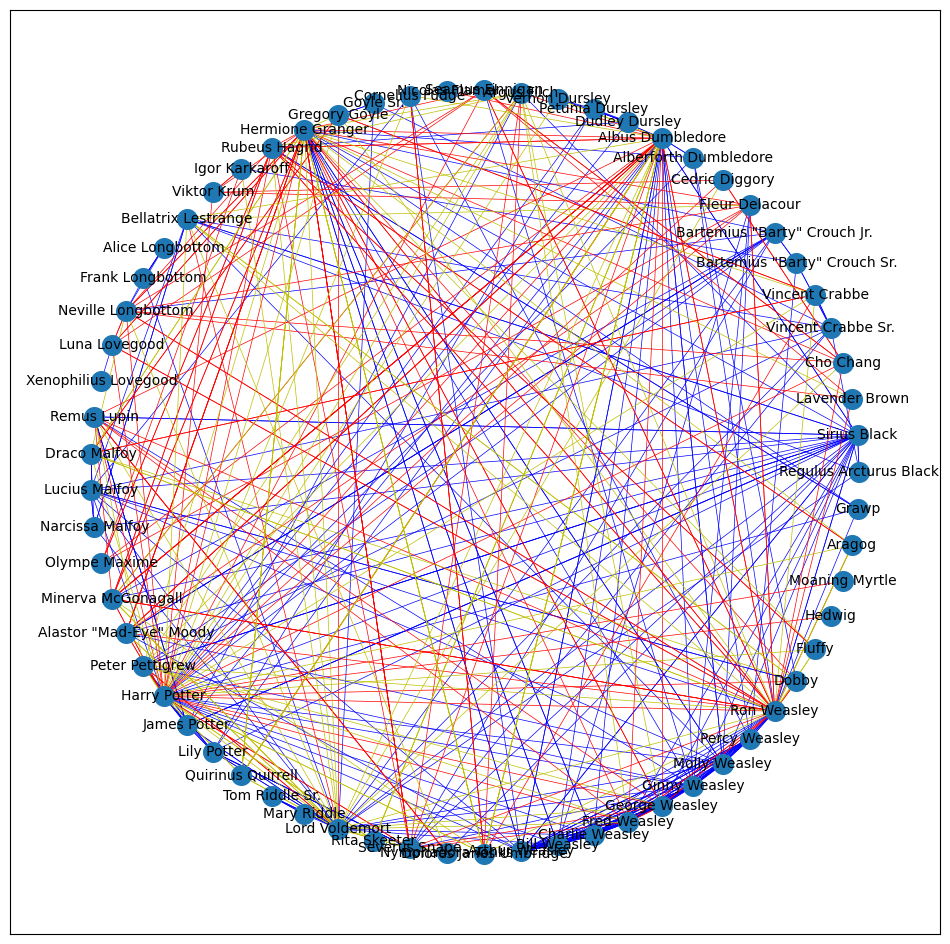

In [18]:
# draw the graph using the pyplot library
plt.figure(3,figsize=(12,12)) 
# draw the nodes
nx.draw_networkx_nodes(G, nx.circular_layout(G), node_size=200)
# draw the positive relationship edges in BLUE
nx.draw_networkx_edges(G, nx.circular_layout(G), edgelist=e_3, edge_color='b', width=0.5)
# draw the negative relationship edges in RED
nx.draw_networkx_edges(G, nx.circular_layout(G), edgelist=e_2, edge_color='r', width=0.5)
# draw the negative relationship edges in GREEN
nx.draw_networkx_edges(G, nx.circular_layout(G), edgelist=e_0, edge_color='g', width=0.5)
# draw the negative relationship edges in YELLOW
nx.draw_networkx_edges(G, nx.circular_layout(G), edgelist=e_n3, edge_color='y', width=0.5)
# add the character names from the mapping as labels
nx.draw_networkx_labels(G, nx.circular_layout(G), labels = mapping, font_size=10, font_family='sans-serif')
# display the plot
plt.show()